### Load Dataset

In [ ]:
!wget https://files.grouplens.org/datasets/movielens/ml-25m.zip

--2024-05-25 18:32:27--  https://files.grouplens.org/datasets/movielens/ml-25m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 261978986 (250M) [application/zip]
Saving to: ‘ml-25m.zip’

ml-25m.zip          100%[===================>] 249.84M  17.3MB/s    in 16s     

2024-05-25 18:32:44 (16.0 MB/s) - ‘ml-25m.zip’ saved [261978986/261978986]



In [ ]:
!unzip -qq ml-25m.zip

In [ ]:
file_ratings = '/content/ml-25m/ratings.csv'
file_movies = '/content/ml-25m/movies.csv'

In [ ]:
import numpy as np
import csv

def create_movie_names(file_path):
    global movie_id_map
    movie_names = np.empty(N, dtype=object)

    with open(file_path, mode='r', newline='', encoding='utf-8') as file:
        reader = csv.DictReader(file)

        for row in reader:
            movie_id = np.int64(row['movieId'])
            movie_name = row['title']

            if movie_id not in movie_id_map:
                continue

            movie_index = movie_id_map[movie_id]
            movie_names[movie_index] = movie_name

    return movie_names


def create_rating_matrix(file_path):
    global user_id_map, movie_id_map
    ratings = []

    with open(file_path, mode='r', newline='', encoding='utf-8') as file:
        reader = csv.DictReader(file)

        for row in reader:
            user_id = np.int64(row['userId'])
            movie_id = np.int64(row['movieId'])
            rating = np.int64(float(row['rating']) * 2)

            if user_id not in user_id_map:
                user_id_map[user_id] = len(user_id_map)

            if movie_id not in movie_id_map:
                movie_id_map[movie_id] = len(movie_id_map)

            user_index = user_id_map[user_id]
            movie_index = movie_id_map[movie_id]

            ratings.append([user_index, movie_index, rating])

    return np.array(ratings)


def index(ratings, index_type="user"):
    locations = []
    i = 0

    if index_type == "user":
        current_id = ratings[0][0]
    else:
        current_id = ratings[0][1]

    locations.append(i)
    for user_id, movie_id, _ in ratings:
        if index_type == "user":
            if current_id != user_id:
                locations.append(i)
                current_id = user_id
            i += 1
        else:
            if current_id != movie_id:
                locations.append(i)
                current_id = movie_id
            i += 1

    return np.array(locations)

In [ ]:
user_id_map = {}
movie_id_map = {}
ratings = create_rating_matrix(file_ratings)
N = len(movie_id_map)
M = len(user_id_map)

In [ ]:
movie_names = create_movie_names(file_movies)

Create dummy user

In [ ]:
new_user_id = 9999999999
user_id_map[new_user_id] = len(user_id_map)
new_user_index = user_id_map[new_user_id]
movie_index = movie_id_map[2116]
ratings = np.vstack((ratings, [new_user_index, movie_index, 10]))
M += 1

In [ ]:
sorted_by_user = ratings[ratings[:, 0].argsort()]
sorted_by_movie = ratings[ratings[:, 1].argsort()]

In [ ]:
user_index = index(sorted_by_user, "user")
movie_index = index(sorted_by_movie , "movie")

In [ ]:
total_ratings = len(ratings)

### ALS updates

In [ ]:
from numba import njit, prange
import numpy as np

@njit
def cal_user_bias_update(rating_matrix, m, user_vector, movie_vector, user_biases, movie_biases):
    movie_indices = rating_matrix[:, 1]
    ratings = rating_matrix[:, 2]

    sum_term = np.sum(
        0.5 * ratings - np.dot(movie_vector[movie_indices], user_vector[m]) - movie_biases[movie_indices]
    )

    return (par_lambda * sum_term) / (par_lambda * len(movie_indices) + par_gamma)


@njit(parallel=True)
def user_bias_update(user_vector, movie_vector, user_biases, movie_biases):
    new_user_biases = np.zeros(M, dtype=np.float64)

    for m in prange(M):
        start_index = user_index[m]
        end_index = user_index[m + 1] if m + 1 < M else total_ratings
        rating_matrix = sorted_by_user[start_index:end_index]

        new_user_biases[m] = cal_user_bias_update(
            rating_matrix, m, user_vector, movie_vector, user_biases, movie_biases
        )

    return new_user_biases


@njit
def cal_user_vector_update(rating_matrix, m, user_vector, movie_vector, user_biases, movie_biases):
    movie_indices = rating_matrix[:, 1]
    ratings = rating_matrix[:, 2]

    t1 = (par_lambda * np.dot(movie_vector[movie_indices].T, movie_vector[movie_indices])) + (par_tau * np.eye(k))
    t2 = par_lambda * np.dot(
        movie_vector[movie_indices].T, 0.5 * ratings - user_biases[m] - movie_biases[movie_indices]
    )

    return np.dot(np.linalg.inv(t1), t2)


@njit(parallel=True)
def user_vector_update(user_vector, movie_vector, user_biases, movie_biases):
    new_user_vector = np.zeros((M, k), dtype=np.float64)

    for m in prange(M):
        start_index = user_index[m]
        end_index = user_index[m + 1] if m + 1 < M else total_ratings
        rating_matrix = sorted_by_user[start_index:end_index]

        new_user_vector[m] = cal_user_vector_update(
            rating_matrix, m, user_vector, movie_vector, user_biases, movie_biases
        )

    return new_user_vector


@njit
def cal_movie_bias_update(rating_matrix, n, user_vector, movie_vector, user_biases, movie_biases):
    user_indices = rating_matrix[:, 0]
    ratings = rating_matrix[:, 2]

    sum_term = np.sum(
        0.5 * ratings - np.dot(user_vector[user_indices], movie_vector[n]) - user_biases[user_indices]
    )

    return (par_lambda * sum_term) / (par_lambda * len(user_indices) + par_gamma)


@njit(parallel=True)
def movie_bias_update(user_vector, movie_vector, user_biases, movie_biases):
    new_movie_biases = np.zeros(N, dtype=np.float64)

    for n in prange(N):
        start_index = movie_index[n]
        end_index = movie_index[n + 1] if n + 1 < N else total_ratings
        rating_matrix = sorted_by_movie[start_index:end_index]

        new_movie_biases[n] = cal_movie_bias_update(
            rating_matrix, n, user_vector, movie_vector, user_biases, movie_biases
        )

    return new_movie_biases


@njit
def cal_movie_vector_update(rating_matrix, n, user_vector, movie_vector, user_biases, movie_biases):
    user_indices = rating_matrix[:, 0]
    ratings = rating_matrix[:, 2]

    t1 = (par_lambda * np.dot(user_vector[user_indices].T, user_vector[user_indices])) + (par_tau * np.eye(k))
    t2 = par_lambda * np.dot(
        user_vector[user_indices].T, 0.5 * ratings - movie_biases[n] - user_biases[user_indices]
    )

    return np.dot(np.linalg.inv(t1), t2)


@njit(parallel=True)
def movie_vector_update(user_vector, movie_vector, user_biases, movie_biases):
    new_movie_vector = np.zeros((N, k), dtype=np.float64)

    for n in prange(N):
        start_index = movie_index[n]
        end_index = movie_index[n + 1] if n + 1 < N else total_ratings
        rating_matrix = sorted_by_movie[start_index:end_index]

        new_movie_vector[n] = cal_movie_vector_update(
            rating_matrix, n, user_vector, movie_vector, user_biases, movie_biases
        )

    return new_movie_vector

### RMSE calculation

In [ ]:
from numba import njit, prange
import numpy as np

@njit
def calc_sum_se(rating_matrix, movie, user_vector, movie_vector, user_biases, movie_biases):
    movie_indices = rating_matrix[:, 1]
    ratings = rating_matrix[:, 2]

    se = np.power(
        0.5 * ratings - np.dot(movie_vector[movie_indices], user_vector[movie]) - movie_biases[movie_indices] - user_biases[movie], 2
    )

    return np.sum(se)

@njit(parallel=True)
def get_rmse(user_vector, movie_vector, user_biases, movie_biases):
    sum_se_per_user = np.zeros(M, dtype=np.float64)

    for m in prange(M):
        start_index = user_index[m]
        end_index = user_index[m + 1] if m + 1 < M else total_ratings
        rating_matrix = sorted_by_user[start_index:end_index]

        sum_se_per_user[m] = calc_sum_se(
            rating_matrix, m, user_vector, movie_vector, user_biases, movie_biases
        )

    sum_se = np.sum(sum_se_per_user)
    rmse = np.sqrt(sum_se / total_ratings)

    return rmse

### Train model

In [ ]:
import numpy as np
import math

k = 10
par_lambda = 0.1
par_tau = 0.1
par_gamma = 0.1

user_biases = np.zeros(M, dtype=np.float64)
movie_biases = np.zeros(N, dtype=np.float64)
user_vector = np.random.normal(loc=0, scale=(1 / math.sqrt(k)), size=(M, k)).astype(np.float64)
movie_vector = np.random.normal(loc=0, scale=(1 / math.sqrt(k)), size=(N, k)).astype(np.float64)

iterations = 50

for i in range(iterations):
    user_biases = user_bias_update(
        user_vector, movie_vector, user_biases, movie_biases
    )
    user_vector = user_vector_update(
        user_vector, movie_vector, user_biases, movie_biases
    )

    movie_biases = movie_bias_update(
        user_vector, movie_vector, user_biases, movie_biases
    )
    movie_vector = movie_vector_update(
        user_vector, movie_vector, user_biases, movie_biases
    )

    rmse = get_rmse(
        user_vector, movie_vector, user_biases, movie_biases
    )

    print(f"Iteration: {i + 1}")
    print(f"RMSE: {rmse}")

Iteration: 1
RMSE: 0.8312999206459868
Iteration: 2
RMSE: 0.7788262752775393
Iteration: 3
RMSE: 0.7466759220203129
Iteration: 4
RMSE: 0.7313855492055249
Iteration: 5
RMSE: 0.7235127443428423
Iteration: 6
RMSE: 0.7189258643018344
Iteration: 7
RMSE: 0.7160251466463813
Iteration: 8
RMSE: 0.7141069387231831
Iteration: 9
RMSE: 0.7128046973244372
Iteration: 10
RMSE: 0.7119034392623506
Iteration: 11
RMSE: 0.7112698552482509
Iteration: 12
RMSE: 0.7108182880162776
Iteration: 13
RMSE: 0.7104916119033441
Iteration: 14
RMSE: 0.7102511819331944
Iteration: 15
RMSE: 0.7100709713242297
Iteration: 16
RMSE: 0.7099334247527748
Iteration: 17
RMSE: 0.7098265821059473
Iteration: 18
RMSE: 0.7097422205405866
Iteration: 19
RMSE: 0.7096746505447615
Iteration: 20
RMSE: 0.7096197959468995
Iteration: 21
RMSE: 0.7095746829697206
Iteration: 22
RMSE: 0.7095371421533965
Iteration: 23
RMSE: 0.709505560757034
Iteration: 24
RMSE: 0.7094787172521706
Iteration: 25
RMSE: 0.7094556782979755
Iteration: 26
RMSE: 0.7094357258880

### Dummy user predictions

In [ ]:
import numpy as np

score = np.dot(movie_vector, user_vector[-1]) + movie_biases
top_10 = np.argsort(score)[-10:][::-1]

for id in top_10:
  print(movie_names[id])

Lord of the Rings, The (1978)
Lord of the Rings: The Return of the King, The (2003)
Lord of the Rings: The Fellowship of the Ring, The (2001)
Dune (1984)
Lord of the Rings: The Two Towers, The (2002)
Star Wars: Episode III - Revenge of the Sith (2005)
Star Wars: Episode II - Attack of the Clones (2002)
Star Wars: Episode VI - Return of the Jedi (1983)
Star Wars: Episode IV - A New Hope (1977)
Star Wars: Episode V - The Empire Strikes Back (1980)


### AB Testing

In [ ]:
user_id_map = {}
movie_id_map = {}
ratings = create_rating_matrix(file_ratings)
N = len(movie_id_map)
M = len(user_id_map)

In [ ]:
movie_names = create_movie_names(file_movies)

Create 100 new users

In [ ]:
import numpy as np

for i in range(100):
  new_user_id = 9999999999+i
  user_id_map[new_user_id] = len(user_id_map)
  new_user_index = user_id_map[new_user_id]
  movie_index = movie_id_map[2116]+i
  ratings = np.vstack((ratings, [new_user_index, movie_index, 10]))
  M += 1

In [ ]:
sorted_by_user = ratings[ratings[:, 0].argsort()]
sorted_by_movie = ratings[ratings[:, 1].argsort()]

In [ ]:
user_index = index(sorted_by_user, "user")
movie_index = index(sorted_by_movie , "movie")

In [ ]:
total_ratings = len(ratings)

### Train model

In [ ]:
import numpy as np
import math

k = 10
par_lambda = 0.1
par_tau = 0.1
par_gamma = 0.1

user_biases = np.zeros(M, dtype=np.float64)
movie_biases = np.zeros(N, dtype=np.float64)
user_vector = np.random.normal(loc=0, scale=(1 / math.sqrt(k)), size=(M, k)).astype(np.float64)
movie_vector = np.random.normal(loc=0, scale=(1 / math.sqrt(k)), size=(N, k)).astype(np.float64)

iterations = 50

for i in range(iterations):
    user_biases = user_bias_update(
        user_vector, movie_vector, user_biases, movie_biases
    )
    user_vector = user_vector_update(
        user_vector, movie_vector, user_biases, movie_biases
    )

    movie_biases = movie_bias_update(
        user_vector, movie_vector, user_biases, movie_biases
    )
    movie_vector = movie_vector_update(
        user_vector, movie_vector, user_biases, movie_biases
    )

    rmse = get_rmse(
        user_vector, movie_vector, user_biases, movie_biases
    )

    print(f"Iteration: {i + 1}")
    print(f"RMSE: {rmse}")

Iteration: 1
RMSE: 0.8296553408670183
Iteration: 2
RMSE: 0.7735868248207406
Iteration: 3
RMSE: 0.7430919527865062
Iteration: 4
RMSE: 0.7286662464417641
Iteration: 5
RMSE: 0.7215371952026308
Iteration: 6
RMSE: 0.7176140764547054
Iteration: 7
RMSE: 0.715216564633943
Iteration: 8
RMSE: 0.7136327520336869
Iteration: 9
RMSE: 0.7125376384007548
Iteration: 10
RMSE: 0.7117666811934913
Iteration: 11
RMSE: 0.711221539200816
Iteration: 12
RMSE: 0.7108354242919087
Iteration: 13
RMSE: 0.7105602076052189
Iteration: 14
RMSE: 0.7103615799325019
Iteration: 15
RMSE: 0.710215777115921
Iteration: 16
RMSE: 0.7101066990461827
Iteration: 17
RMSE: 0.7100235108242062
Iteration: 18
RMSE: 0.7099588316816149
Iteration: 19
RMSE: 0.7099075469592374
Iteration: 20
RMSE: 0.7098660581390851
Iteration: 21
RMSE: 0.7098317910595031
Iteration: 22
RMSE: 0.7098028826826384
Iteration: 23
RMSE: 0.7097779785430018
Iteration: 24
RMSE: 0.7097560918882829
Iteration: 25
RMSE: 0.7097365010896609
Iteration: 26
RMSE: 0.709718675034602

### Croup A

In [ ]:
import random
import numpy as np

A_feedback = []
for i in range(1,51):
  score = np.dot(movie_vector, user_vector[-i]) + 0.5*movie_biases
  top_10 = np.argsort(score)[-10:][::-1]


  feedback = np.zeros(10).astype(np.int64)
  j = 0
  for movie_index in top_10:
    feedback[j] = random.choice([1, 0])
    j+=1

  A_feedback.append(feedback)

### Group B

In [ ]:
import random
import numpy as np

B_feedback = []
for i in range(51,101):
  score = np.dot(movie_vector, user_vector[-i]) + 0.5*movie_biases
  top_10 = np.argsort(score)[-10:][::-1]


  feedback = np.zeros(10).astype(np.int64)
  j = 0
  for movie_index in top_10:
    feedback[j] = random.choice([1, 0])
    j+=1

  B_feedback.append(feedback)

### Perform t-test

In [ ]:
from scipy import stats
import seaborn as sns
import numpy as np

A_feedback = np.concatenate(A_feedback)
B_feedback = np.concatenate(B_feedback)

t_stat, p_value = stats.ttest_ind(A_feedback, B_feedback)

print(f'T-statistic: {t_stat}')
print(f'P-value: {p_value}')

T-statistic: 0.7584604068611095
P-value: 0.44835448027394165


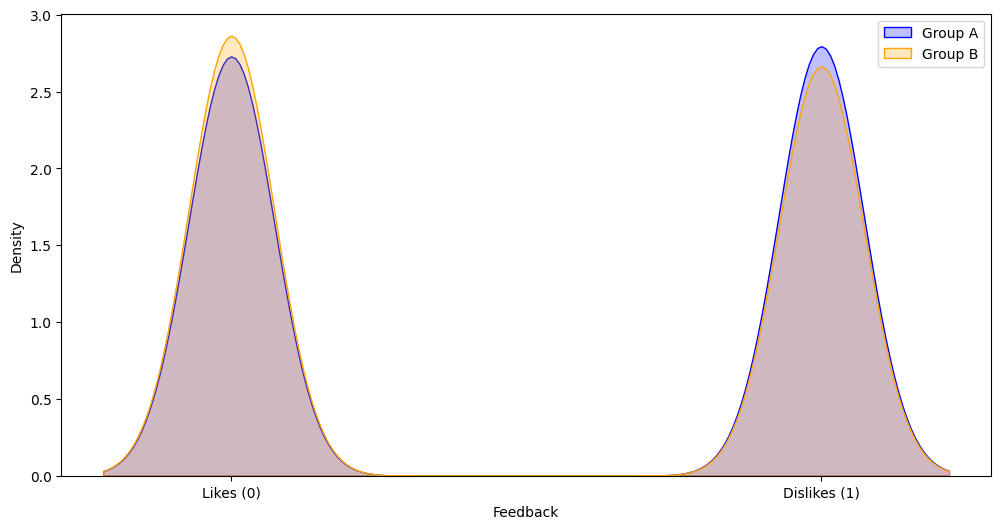

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.kdeplot(A_feedback, bw_adjust=0.5, label='Group A', color='blue', fill=True)
sns.kdeplot(B_feedback, bw_adjust=0.5, label='Group B', color='orange', fill=True)
plt.xticks([0, 1], ['Likes (0)', 'Dislikes (1)'])
plt.xlabel('Feedback')
plt.ylabel('Density')
plt.legend()
plt.savefig('feedback_distribution.pdf')
plt.show()